In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import csv
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from nltk.corpus import stopwords

# for named entity
from nltk import word_tokenize, pos_tag, ne_chunk, tree, download
%matplotlib inline
download("punkt")


# nltk for natural language processing

In [5]:
path =r'./playstorereviewsdata/' # use your path
allFiles = glob.glob(path + "/*.tsv")

review_data = [];
count = 0
for out_count, file in enumerate(allFiles):
    with open(file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        #import pdb;pdb.set_trace()
        for counter, row in enumerate(spamreader):
            #import pdb;pdb.set_trace()
            count += 1
            if counter == 0:
                text_index = row.index("Review Text")
                title_index = row.index("Review Title")
                rating_index = row.index("Star Rating")
                #print(text_index, title_index, rating_index)
            else:
                for item in row[text_index].split('.'):
                    if not re.findall(r'[\w.-]+@[\w.-]+',item):
                        review_data.append({
                            "Review Text": item,
                            "Review Title": row[title_index],
                            "Star Rating": int(row[rating_index])
                        })
            
#     with open(file+out_count, 'wt') as csvfile:
#             writer = csv.writer(csvfile, delimiter='', quotechar='|')
#             #writer.writerow(["#"] + anarkali_characteristics)
#             #import pdb;pdb.set_trace()
#             for element in lehenga_characteristics:
#                 #import pdb;pdb.set_trace()
#                 writer.writerow([element["name"], element["count"]])

In [6]:
# get full data


frame = pd.DataFrame()
list_ = []

# datacolumns = [
#     "Package Name",
#     "App Version Code",
#     "Reviewer Language",
#     "Device",
#     "Review Submit Date and Time",
#     "Review Submit Millis Since Epoch",
#     "Review Last Update Date and Time",
#     "Review Last Update Millis Since Epoch",
#     "Star Rating",
#     "Review Title",
#     "Review Text",
#     "Developer Reply Date and Time",
#     "Developer Reply Millis Since Epoch",
#     "Developer Reply Text,Review Link"
# ]

# for item in allFiles:
    

# for file_ in allFiles:
#     df = pd.read_csv(file_,index_col=None, header=0, encoding = "ISO-8859-1", error_bad_lines=False, sep='\t')
#     list_.append(df)
    
    
# full_data = pd.concat(list_)

#import pdb;pdb.set_trace()
full_data = pd.DataFrame(review_data)
full_data.count()

# import pdb;pdb.set_trace()
# full_data1 = pd.concat(list_)
# full_data1.count()

Review Text     22790
Review Title    22790
Star Rating     22790
dtype: int64

In [7]:
# remove the NaN 
full_data["Review Text"] = full_data["Review Text"].fillna('')
full_data["Review Title"] = full_data["Review Title"].fillna('')
# full_data["App Version Code"] = full_data["App Version Code"].fillna(0.0)
# full_data["App Version Name"] = full_data["App Version Name"].fillna('')
# full_data["Developer Reply Date and Time"] = full_data["Developer Reply Date and Time"].fillna('')
# full_data["Developer Reply Millis Since Epoch"] = full_data["Developer Reply Millis Since Epoch"].fillna('')
# full_data["Developer Reply Text"] = full_data["Developer Reply Text"].fillna('')

# slicing the required columns only
#full_data = full_data[["Review Text", "Review Title", "Star Rating"]]

In [8]:
full_data.head(5)

,Review Text,Review Title,Star Rating
0,This is a brilliant concept,Great product!,5
1,Please start for men's asap,Great product!,5
2,Brilliant concept :),,5
3,,,5
4,Brilliant stuff!! Waiting to see more,,5


In [9]:
full_data = full_data.loc[full_data['Review Text'] != '']
full_data["Positive"] = full_data['Star Rating'] >= 4
full_data["Negative"] = full_data['Star Rating'] <= 3

#import pdb;pdb.set_trace()
positive_data = full_data.loc[(full_data['Negative'] == True)][:1331]
negative_data = full_data.loc[(full_data['Positive'] == True)][:1331]

# add a named entities to look for
#import pdb;pdb.set_trace()

sliced_data = positive_data.append(negative_data)





#sliced_data["Named Entities"] = [ne_chunk(pos_tag(word_tokenize(item))) for item in sliced_data['Review Text'].tolist()] 

In [10]:
input_df = sliced_data[['Review Text', 'Star Rating']]
sliced_data['Review Text']

99            What's the access code???I am stuck there!!
101                                  Stuck in access code
102                   Quickly send or give an invite code
103                                                   com
186     I'm glad this thing is now available in India too
187      Like, FINALLY! Looking forward for the servic...
238                      how to log in??? access code????
243     What's d use if v can now take access with out...
246                                         N wats d code
261                                       Hiii management
264                       how do I login inn into the app
265                                                   com
285                                 I'm not able to login
346     I have trouble accessing to d special dresses ...
349          also do you offer traditional wear for rent?
353            Dsnt install on my phone 😣 please help out
354                           Keeps on throwing error 504
358     It's n

In [11]:
sliced_data.loc[sliced_data['Positive'] == True].__len__()


1331

In [12]:
sliced_data.loc[sliced_data['Negative'] == True].__len__()

1331

In [13]:
# bring the data with probability tech + , tech - , ops + , ops - , product + , product -
import re
tech_list = ["tech", "issue", "coupon", "order placed", "coupon issue", "tech issue", "App crash", "web crash", "ios", 
            "android", "signup issue", "signin issue", "order placed", "order confirmation", "online payment", "hang", "too slow"
            , "cart", "image not matching", "website", "android", "ios", "online"]
ops_list = ["delivery", "measurement", "pickup", "refund",  "fitting", "trial", "pickup", "refund", "deposit", "on-time", "delay", "address updation", "return", "cancellation", "exchange",
"payment issues"]
product_list = ["content", "available", "error", "loading", "website not loading", "site not loading", "content not available", "cloth tear", "defective product", "discount codes", "?"]

def calculate_token_probability(item):
    tech = 0; ops = 0; product = 0
    tokens = item['Review Text'].split(' ')
#     for element in tokens:
#         #import pdb;pdb.set_trace()
#         try:
#             tech_match = re.findall(element.lower(), tech_str)
#         except Exception:
#             tech_match = None
            
#         try:
#             ops_match = re.findall(element.lower(), ops_str)
#         except Exception:
#             ops_match = None
            
#         try:
#             product_match = re.findall(element.lower(), product_str)
#         except Exception:
#             product_match = None
#         if tech_match:
#             tech += 1
#         elif ops_match:
#             ops += 1
#         elif product_match:
#             product += 1
    tech = [1 for tech_i in tech_list if tech_i.lower() in item['Review Text']]
    ops = [1 for ops_i in ops_list if ops_i.lower() in item['Review Text']]
    product = [1 for product_i in product_list if product_i.lower() in item['Review Text']]
    

#     for tech_i in tech_list:
#         try:
#             tech_match = re.findall(tech_i.lower(), item['Review Text'])
#         except Exception:
#             tech_match = None
            
#         if tech_match:
#              tech += 1
    
#     for ops_i in ops_list:
#         try:
#             ops_match = re.findall(ops_i.lower(), item['Review Text'])
#         except Exception:
#             ops_match = None
            
#         if ops_match:
#              ops += 1
    
#     for product_i in product_list:
#         try:
#             product_match = re.findall(product_i.lower(), item['Review Text'])
#         except Exception:
#             product_match = None
            
#         if product_match:
#              product += 1
            
    tech_sum = sum(tech)
    ops_sum = sum(ops)
    product_sum = sum(product)
    
    sum_all = tech_sum + ops_sum + product_sum
    try:
        return pd.Series({'tech_prob': tech_sum/sum_all, 'ops_prob': ops_sum/sum_all, 'product_prob': product_sum/sum_all})
    except Exception: 
        return pd.Series({'tech_prob': 0, 'ops_prob': 0, 'product_prob': 0})
    
    
# def cal(item):
#     print(item['Review Text'])
#     return pd.Series({'hello': item}, )
    
# probability = sliced_data.apply(calculate_token_probability, axis=1)

# final_sliced_data = pd.concat([ sliced_data , probability], axis=1)


# final_sliced_data['ops_positive'] = (( final_sliced_data['ops_prob'] == final_sliced_data[['ops_prob', 'tech_prob', 'product_prob']].max(axis=1) ) & final_sliced_data["Positive"] == True).astype(int).values
# final_sliced_data['product_positive'] = (( final_sliced_data['product_prob'] == final_sliced_data[['ops_prob', 'tech_prob', 'product_prob']].max(axis=1) ) & final_sliced_data["Positive"] == True ).astype(int).values
# final_sliced_data['tech_positive'] = (( final_sliced_data['tech_prob'] == final_sliced_data[['ops_prob', 'tech_prob', 'product_prob']].max(axis=1)  ) & final_sliced_data["Positive"] == True).astype(int).values
# final_sliced_data['ops_negative'] = (( final_sliced_data['ops_prob'] == final_sliced_data[['ops_prob', 'tech_prob', 'product_prob']].max(axis=1) ) & final_sliced_data["Negative"] == True).astype(int).values
# final_sliced_data['product_negative'] = (( final_sliced_data['product_prob'] == final_sliced_data[['ops_prob', 'tech_prob', 'product_prob']].max(axis=1) ) & final_sliced_data["Negative"] == True).astype(int).values
# final_sliced_data['tech_negative'] = (( final_sliced_data['tech_prob'] == final_sliced_data[['ops_prob', 'tech_prob', 'product_prob']].max(axis=1) ) & final_sliced_data["Negative"] == True).astype(int).values
# final_sliced_data

In [14]:
tags = tech_list + ops_list + product_list

def get_review_tags(item):
    tech = 0; ops = 0; product = 0
    sentences = item['Review Text'].split('.')
    tag_dict = {}
    for tag in tags:
        for sentence in sentences:
            if tag.lower() not in tag_dict.keys():
                #import pdb;pdb.set_trace()
                tag_dict[tag.lower()] = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(tag.lower()), sentence.lower()))
            else:
                #import pdb;pdb.set_trace()
                tag_dict[tag.lower()] += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(tag.lower()), sentence.lower()))
    try:
        if list(tag_dict.values()).count(0) == len(tag_dict.keys()):
            return pd.Series({"tag": "N/A"})
        return pd.Series({"tag": sorted(tag_dict, reverse=True)[0]})
    except Exception:
        return pd.Series({"tag": "N/A"})
            
buckets = sliced_data.apply(get_review_tags, axis=1)
final_sliced_data = pd.concat([ sliced_data , buckets], axis=1)
final_sliced_data

,Review Text,Review Title,Star Rating,Positive,Negative,tag
99,What's the access code???I am stuck there!!,Great!!,3,False,True,N/A
101,Stuck in access code,Access code,2,False,True,N/A
102,Quickly send or give an invite code,NEED AN iNVITE,3,False,True,N/A
103,com,NEED AN iNVITE,3,False,True,N/A
186,I'm glad this thing is now available in India too,,3,False,True,website not loading
187,"Like, FINALLY! Looking forward for the servic...",,3,False,True,N/A
238,how to log in??? access code????,,3,False,True,N/A
243,What's d use if v can now take access with out...,,1,False,True,N/A
246,N wats d code,,1,False,True,N/A
261,Hiii management,Pls help to loginn !!,3,False,True,N/A


In [15]:
sliced_data['Review Text'].head(5)

99           What's the access code???I am stuck there!!
101                                 Stuck in access code
102                  Quickly send or give an invite code
103                                                  com
186    I'm glad this thing is now available in India too
Name: Review Text, dtype: object

In [16]:
sliced_data.head(5)

,Review Text,Review Title,Star Rating,Positive,Negative
99,What's the access code???I am stuck there!!,Great!!,3,False,True
101,Stuck in access code,Access code,2,False,True
102,Quickly send or give an invite code,NEED AN iNVITE,3,False,True
103,com,NEED AN iNVITE,3,False,True
186,I'm glad this thing is now available in India too,,3,False,True


In [17]:
# generate csv file
sliced_data.to_csv("review_text_data.tsv", sep='\t')

In [18]:
sliced_data.loc[sliced_data['Negative'] == True].__len__()

1331

In [19]:
sliced_data.loc[sliced_data['Positive'] == True].__len__()

1331

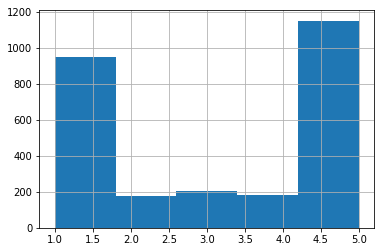

In [20]:
sliced_data['Star Rating'].hist(bins=5)

In [21]:
class WordWeightAssign:
    """
        This is the class to assign the word and its weight
    """
    def __init__(self, data):
        self.data = data
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.add('')
        self.corpus = " ".join([" ".join(item) for item in self.data])
        
    def word_count(self, substring, string):
        count = 0
        words = string.split()
        for word in words:
            if substring == word:
                count += 1
        return count
        
    def collect_data(self):
        self.unique_words = []
        #print(self.stop_words)
        for element in self.data:
            for item in element:
                #print(self.word_count(item, self.corpus))
                if item not in self.stop_words and self.word_count(item, self.corpus) >= 3:
                    self.unique_words.append(item)
        self.unique_words = list(set(self.unique_words))
        return self.unique_words
    
    def score_words(self):
        review_word_scores = []
        #import pdb;pdb.set_trace()
        for item in self.data:
            local_scores = np.zeros((3964,), dtype=np.int)
            for element in item:
                if element not in self.stop_words:
                    try:
                        current_index = self.unique_words.index(element)
                        if current_index:
                            local_scores[current_index] += 1
                    except ValueError:
                        pass
            review_word_scores.append(local_scores)
            #review_word_scores.append((" ".join(item),local_scores))
        #import pdb;pdb.set_trace()
        return review_word_scores

In [22]:
w = WordWeightAssign(sliced_data['Review Text'].str.split(' ').tolist())
print(w.collect_data().__len__())
print(w.score_words().__len__())

1053
2662


In [23]:
sliced_data.to_csv('pos_neg_score.csv', index = False)

In [25]:
#Stratified 10-cross fold validation with SVM and Multinomial NB 
#labels = np.zeros(1000);
labels = (sliced_data["Positive"] == True).astype(int).values;

#import pdb;pdb.set_trace()  
kf = StratifiedKFold(n_splits=4)

totalsvm = 0           # Accuracy measure on 1000 files
totalNB = 0
totalMLP = 0
totalNBFV = 0
totalMatSvm = np.zeros((2,2));  # Confusion matrix on 1000 files
totalMatNB = np.zeros((2,2));
totalMatMLP = np.zeros((2,2));
totalMatNBFV = np.zeros((2,2));

# tr, te = kf.split(sliced_data['Review Text'], labels)
# td = []
# for i in train_index:
#     td.append(sliced_data['Review Text'][i])
#import pdb;pdb.set_trace()
review_text = sliced_data['Review Text'].tolist()

# break words
review_words = []

# for item in review_text:
#     review_words += item.split(" ")
counter = 0
for train_index, test_index in kf.split(review_text, labels):
    #import pdb;pdb.set_trace()
    #print(train_index.__len__(), test_index.__len__())
    X_train = [review_text[i] for i in train_index]
    X_test = [review_text[i] for i in test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=False, stop_words='english')
    train_corpus_tf_idf = vectorizer.fit_transform(X_train) 
    test_corpus_tf_idf = vectorizer.transform(X_test)
    
    #import pdb;pdb.set_trace()
    splitted_x_train = [item.split(' ') for item in X_train]
    w = WordWeightAssign(splitted_x_train)
    w.collect_data()
    w.score_words()
    train_corpus_scores = w.score_words()
    
    splitted_x_test = [item.split(' ') for item in X_test]
    w = WordWeightAssign(splitted_x_test)
    w.collect_data()
    w.score_words()
    test_corpus_scores = w.score_words()
    model1 = LinearSVC()
    model2 = MultinomialNB()
    model3 = MLPClassifier()
    nb = MultinomialNB()
    # Max entropy
    model1.fit(train_corpus_tf_idf,y_train)
    model2.fit(train_corpus_tf_idf,y_train)
    model3.fit(train_corpus_tf_idf,y_train)
    #import pdb;pdb.set_trace()
    nb.fit(train_corpus_scores, y_train)
    
    result1 = model1.predict(test_corpus_tf_idf)
    result2 = model2.predict(test_corpus_tf_idf)
    result3 = model3.predict(test_corpus_tf_idf)
    
    result4 = nb.predict(test_corpus_scores)
    
    test1 = model1.score(test_corpus_tf_idf, y_test)
    test2 = model2.score(test_corpus_tf_idf, y_test)
    test3 = model3.score(test_corpus_tf_idf, y_test)
    test4 = nb.score(test_corpus_scores, y_test)
    print(test1, test2, test3, test4)
    
    totalMatSvm = totalMatSvm + confusion_matrix(y_test, result1)
    totalMatNB = totalMatNB + confusion_matrix(y_test, result2)
    totalMatMLP = totalMatMLP + confusion_matrix(y_test, result3)
    totalMatNBFV = totalMatNBFV + confusion_matrix(y_test, result4)
    totalsvm = totalsvm + sum(y_test==result1)
    totalNB = totalNB + sum(y_test==result2)
    totalMLP = totalMLP + sum(y_test==result3)
    totalNBFV = totalNBFV + sum(y_test==result3)
    counter += 1
    test_data = ["I do not liked the service.", "What is the point of starting this when you can not deliver items on time", "Is it really working in India ?"]
    splitted_x_test_ = [item.split(' ') for item in test_data]
    w = WordWeightAssign(splitted_x_test_)
    w.collect_data()
    test_corpus = w.score_words()
    
    result_test = nb.predict(test_corpus)
    print(result_test)
    prev = sliced_data.iloc[test_index, :]
    test = pd.DataFrame( { 'Review Text': X_test , 'Sentiment': result4, 
                          'Positive': prev["Positive"], 
                          'Negative': prev["Negative"],
                         'Star Rating': prev["Star Rating"]} )
    test.to_csv( 'sentiment_prediction'+str(counter)+'.csv' , index = False )
    
    
print(totalMatSvm, totalsvm/2662.0, totalMatNB, totalNB/2662.0, totalMatMLP, totalMLP/2662.0)


#print(totalMatSvm, totalsvm, totalMatNB, totalNB, totalMatMLP, totalMLP)
#test.to_csv( 'sentiment_prediction.csv' , index = False )

#print(train_corpus_tf_idf, test_corpus_tf_idf)
#import pdb;pdb.set_trace()
#print(test_corpus_tf_idf, X_test[0])

test_Y = model2.predict( test_corpus_tf_idf )
#print(test_Y)
print(counter)
#print(X_test)

#print(results_list)
#print(review_text.reset_index(drop=True))
#print(review_text)
# test = pd.DataFrame( { 'Review Text': review_text , 'Sentiment': test_Y } )
# test.shape
# test.head()
#test.to_csv( 'sentiment_prediction.csv' , index = False )

/Users/chitrankdixit/Documents/work/sentimental_analysis/sentimental/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.696696696697 0.734234234234 0.708708708709 0.447447447447
[0 0 0]
0.71021021021 0.731231231231 0.723723723724 0.477477477477
[0 0 0]
0.743243243243 0.734234234234 0.726726726727 0.525525525526
[0 0 0]
0.609939759036 0.69578313253 0.647590361446 0.472891566265
[0 0 0]
[[ 996.  335.]
 [ 490.  841.]] 0.690082644628 [[ 1046.   285.]
 [  450.   881.]] 0.723891810669 [[ 908.  423.]
 [ 371.  960.]] 0.701728024042
4


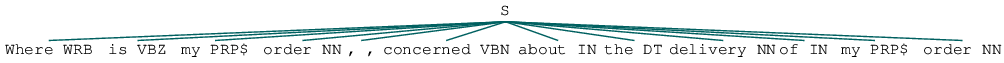

In [75]:

sentence = "Where is my order, concerned about the delivery of my order"
 
chunk = ne_chunk(pos_tag(word_tokenize(sentence)))
chunk

In [76]:
from collections import defaultdict

tech = ["order placed", "tech", "issue", "coupon", "item"]
ops = ["delivery", "measurement", "pickup", "refund"]
product = ["site content", "content not available", "error at site", "site not loading"]

def nltk_entities(review_texts=None):
    """
    Extract entities using the NLTK named entity chunker.
    """
    results = defaultdict(lambda: defaultdict(list))
    #fileids = fileids or corpus.fileids()

    for count, review in enumerate(review_texts):
        #print(review)
        #import pdb;pdb.set_trace()
#         if section is not None:
#             text = nltk.pos_tag(nltk.word_tokenize(list(sectpull([fileid],section=section))[0][1]))
#         else:
#             text = nltk.pos_tag(corpus.words(fileid))
#         text =  pos_tag(review)
#         print(text)
        for entity in ne_chunk(pos_tag(word_tokenize(review))):
            
            if isinstance(entity, tree.Tree):
                etext = " ".join([word for word, tag in entity.leaves()])
                print(entity.leaves())
                label = entity.label()
            else:
                continue
            #print(entity)
            if label == 'PERSON':
                key = 'persons'
            elif label == 'ORGANIZATION':
                key = 'organizations'
            elif label == 'LOCATION':
                key = 'locations'
            elif label == 'GPE':
                key = 'other'
            elif label in tech:
                key = 'tech'
            elif label in ops:
                key = 'ops'
            elif label in product:
                key = 'product'
            
            else:
                key = None
                
            #print("________",label)
            
            if key:
                results[count][key].append(etext)

    return results


review_text_list = ["Mark and John are working at Google." , "Awesome collection in Flyrobe", "Where is my order, concerned about the delivery of my order"] 
nltkents = nltk_entities(review_text_list)

[('Mark', 'NNP')]
[('John', 'NNP')]
[('Google', 'NNP')]
[('Awesome', 'NNP')]
[('Flyrobe', 'NNP')]


In [77]:
nltkents

defaultdict(<function __main__.nltk_entities.<locals>.<lambda>>,
            {0: defaultdict(list,
                         {'organizations': ['Google'],
                          'persons': ['Mark', 'John']}),
             1: defaultdict(list, {'other': ['Awesome', 'Flyrobe']})})

In [78]:
a = {"1": 12, "23": 46}
print(sorted(a, reverse=True))

['23', '1']


In [79]:
a = {"1": 12, "23": 46, "12": 0, "24": 0}
list(a.values()).count(0) 

2

In [35]:
a = np.zeros((5,), dtype=np.int)
a

array([0, 0, 0, 0, 0])

In [36]:
a[4] = 1

In [37]:
a

array([0, 0, 0, 0, 1])